In [3]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# 数据准备
def normalize_data(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val), min_val, max_val

In [6]:

# 定义模型
# 定义新模型
class ODModel(nn.Module):
    def __init__(self, N, temp, freq):
        super(ODModel, self).__init__()

        self.N = N  # 区域数
        self.temp = temp  # 频域差距 [N,]
        self.freq = freq  # 频域差距 [N,]
        n1 = 128  # 隐藏层神经元1
        n2 = 64  # 隐藏层神经元2

        # 权重[α1,α2,α3] --> shape [N, 3]
        self.weights = nn.Parameter(torch.randn(N, 3))

        # MLP层 input [B,N] --> output [B,N*N]
        self.mlp = nn.Sequential(
            nn.Linear(N, n1),
            nn.ReLU(),
            nn.Linear(n1, n2),
            nn.ReLU(),
            nn.Linear(n2, N * N)
        )

    def forward(self, x):
        '''
        前向传播
        :param x: Batch输入Speed --> [B,N]
        :return: Batch输出OD     --> [B,N,N]
        '''
        B,N = x.shape  # [B,N]

        x_temp = np.tile(self.temp, (B, 1))  # [B,N]
        x_freq = np.tile(self.freq, (B, 1))  # [B,N]

        x_random = np.random.normal(loc=0.05, scale=0.01, size=(B, N)).astype(float)  # [B,N]
        x_random = np.clip(x_random, 0, 0.1)



        x_temp_freq_rand = np.stack([x_temp, x_freq, x_random], axis=-1)  # [B,N,3]
        tensor_delta_x = torch.tensor(x_temp_freq_rand,dtype=torch.float).to(x.device)


        self.weights = self.weights.to(x.device)
        weighted_sum = x + torch.sum(tensor_delta_x * self.weights.unsqueeze(0), dim=2)


        # 输入到 MLP 网络中
        od_matrix_flat = self.mlp(weighted_sum)  # [B,N] --> [B, N * N]
        # reshape 最终输出
        od_matrix = od_matrix_flat.view(B, N, N)  # [B, N, N]

        return od_matrix

In [7]:
# 保存日志文件
log_filename = f"log/v1_2/training_log_25.1.14版本_{time.strftime('%Y%m%d_%H%M%S')}.log"
with open(log_filename, 'w') as log_file:
    log_file.write("Epoch, Train Loss, Validation Loss\n")

In [8]:
# 训练过程
def train_model(model, train_loader, val_loader, epochs=100, patience=10, learning_rate=0.001, load=0):
    if load == 1:
        model.load_state_dict(torch.load('ckpt/v1_2/best_model_feature4_25.1.14数据集版本.pth'))
        print(f"best model loaded")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 学习率调度器
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    best_val_loss = float('inf')
    patience_counter = 0
    N = 110

    # 训练过程
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device).float(), targets.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 计算训练集的平均损失
        train_loss /= len(train_loader)

        # 验证过程
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device).float(), targets.to(device).float()

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # 计算验证集的平均损失
        val_loss /= len(val_loader)

        # 保存每一轮的损失，并打印
        with open(log_filename, 'a') as log_file:
            log_file.write(f"{epoch + 1}, {train_loss:.4f}, {val_loss:.4f}\n")

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        # ({optimizer.param_groups[0]['lr']:.6f})

        # 提前停止机制
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), "ckpt/v1_2/best_model_feature4_25.1.14数据集版本.pth")
            print(f"best saved at epoch{epoch + 1},best：{best_val_loss:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # 绘制训练过程中的损失曲线
    with open(log_filename, 'r') as log_file:
        epochs_list, train_loss_list, val_loss_list = [], [], []
        for line in log_file.readlines()[1:]:
            epoch, train_loss, val_loss = line.strip().split(", ")
            epochs_list.append(int(epoch))
            train_loss_list.append(float(train_loss))
            val_loss_list.append(float(val_loss))

    plt.plot(epochs_list, train_loss_list, label='Train Loss')
    plt.plot(epochs_list, val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'train and validation loss with lr={learning_rate}')
    plt.savefig("loss_curve.png")
    plt.show()

    return best_val_loss

In [9]:
# 加载数据
def load_data():
    set_seed(42)

    # 加载数据
    data = np.load('data/武汉速度数据集_1KM_110区域_25.1.14.npy')  # 形状 [T, N, 2]
    speed = data[:, :, 0]  # 平均速度 [T, N]

    od = np.load('data/武汉OD数据集_1KM_110区域_过滤cnt_对角线0_25.1.14.npy')  # 形状 [T, N, N]

    # 获取数据长度 T
    T, N = speed.shape

    # 按顺序划分数据
    train_size = int(T * 0.6)
    val_size = int(T * 0.2)

    # 顺序划分索引
    train_indices = np.arange(0, train_size)
    val_indices = np.arange(train_size, train_size + val_size)
    test_indices = np.arange(train_size + val_size, T)

    # 按索引划分数据
    speed_train, speed_val, speed_test = speed[train_indices], speed[val_indices], speed[test_indices]
    od_train, od_val, od_test = od[train_indices], od[val_indices], od[test_indices]
    # x_random_train, x_random_val, x_random_test = x_random[train_indices], x_random[val_indices], x_random[test_indices]

    # 输出划分后的数据形状
    print("6:2:2顺序划分的训练集Speed", speed_train.shape, "OD", od_train.shape)
    print("6:2:2顺序划分的验证集Speed", speed_val.shape, "OD", od_val.shape)
    print("6:2:2顺序划分的测试集Speed", speed_test.shape, "OD", od_test.shape)

    # 在训练集上计算 OD 出发总量
    od_train_departures = np.sum(od_train, axis=-1)  # 形状 [T_train, N]

    # 计算每个区域在 T_train 时间步的平均速度和平均出发总量
    mean_speed = np.mean(speed_train, axis=0)  # 每个区域的平均速度 [N,]
    mean_departures = np.mean(od_train_departures, axis=0)  # 每个区域的平均出发总量 [N,]
    # 计算平均速度和平均出发总量的差值
    temporal = (mean_departures - mean_speed).astype(float)  # [N,]

    # freq
    speed_freq = np.load('data/速度的周期状态_对应25.1.14的速度数据集.npy')  # 形状 [N,]
    od_freq = np.load('data/OD的周期状态_对应25.1.14的OD数据集.npy')  # 形状 [N,]

    freq = (od_freq - speed_freq).astype(float)

    # 归一化
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(speed_train.reshape(-1, 1)).reshape(speed_train.shape)
    val_data = scaler.transform(speed_val.reshape(-1, 1)).reshape(speed_val.shape)
    test_data = scaler.transform(speed_test.reshape(-1, 1)).reshape(speed_test.shape)

    print(f"train_data: {train_data[:10, 66]}")


    train_data = torch.tensor(train_data, dtype=torch.float32)
    val_data = torch.tensor(val_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)

    train_target = torch.tensor(od_train, dtype=torch.float32)
    val_target = torch.tensor(od_val, dtype=torch.float32)
    test_target = torch.tensor(od_test, dtype=torch.float32)

    # 打印结果形状
    print("归一化后的训练集 shape:", train_data.shape, "OD形状", train_target.shape)
    print("归一化后的验证集 shape:", val_data.shape, "OD形状", val_target.shape)
    print("归一化后的测试集 shape:", test_data.shape, "OD形状", test_target.shape)

    train_dataset = TensorDataset(train_data, train_target)
    val_dataset = TensorDataset(val_data, val_target)
    test_dataset = TensorDataset(test_data, test_target)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    scaler = MinMaxScaler()
    x_temp = scaler.fit_transform(temporal.reshape(-1, 1))
    scaler = MinMaxScaler()
    x_freq = scaler.fit_transform(freq.reshape(-1, 1))
    x_temp = np.squeeze(x_temp, axis=-1)
    x_freq = np.squeeze(x_freq, axis=-1)

    return train_loader, val_loader, test_loader, x_temp, x_freq


In [10]:
def calculate_rmse_mae(predictions, targets):
    mse = torch.mean((predictions - targets) ** 2)
    rmse = torch.sqrt(mse)
    mae = torch.mean(torch.abs(predictions - targets))
    return rmse.item(), mae.item()


def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 设置所有GPU的随机种子



In [11]:
# 测试
def test_model(model, test_loader, lr: float):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.load_state_dict(torch.load("ckpt/v1_2/best_model_feature4_25.1.14数据集版本.pth"))

    # 打印结构
    # summary(model, input_size=(32, 110, 4))

    model.eval()
    test_loss = 0
    rmse_total = 0
    mae_total = 0
    criterion = nn.MSELoss()
    N = 110

    all_real_od = []
    all_pred_od = []

    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # 设置对角线掩码
            mask = torch.ones_like(targets)
            for i in range(N):
                mask[:, i, i] = 0  # 对角线上的元素设为 0

            print(f"输入:{inputs.shape},标签:{targets.shape}")

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # 计算 RMSE 和 MAE
            rmse, mae = calculate_rmse_mae(outputs * mask, targets)
            rmse_total += rmse
            mae_total += mae

            all_real_od.append(targets.cpu().numpy())
            all_pred_od.append(outputs.cpu().numpy())

    test_loss /= len(test_loader)
    rmse_total /= len(test_loader)
    mae_total /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test RMSE: {rmse_total:.4f} Test MAE: {mae_total:.4f}")
    with open(log_filename, 'a') as log_file:
        log_file.write(f"Test RMSE: {rmse_total:.4f}, MAE: {mae_total:.4f}\n")
    torch.save(model.state_dict(),
               f"ckpt/v1_2/best_model_feature4_25.1.14数据集版本_{test_loss:.4f}_{rmse_total:.4f}_{mae_total:.4f}_lr_{lr}.pth")

    # 计算平均的OD矩阵
    # 设置不使用科学计数法
    np.set_printoptions(precision=2, suppress=True)
    all_real_od_t = np.concatenate(all_real_od, axis=0)
    all_pred_od_t = np.concatenate(all_pred_od, axis=0)
    all_real_od = np.mean(all_real_od_t, axis=0)
    all_pred_od = np.mean(all_pred_od_t, axis=0)

    print("-------------------不同时间步上---------------------")
    for i in range(0, all_real_od_t.shape[0], 8):
        print("-----真实值------")
        print(np.round(all_real_od_t[i, 60:68, 60:68].astype(np.float32)))  # 保留小数点后1位
        print("-----预测值-----")
        print(np.round(all_pred_od_t[i, 60:68, 60:68].astype(np.float32)))  # 保留小数点后1位

    print("-------------------平均时间步上---------------------")
    print(np.round(all_real_od[60:68, 60:68].astype(np.float32), 0).astype(int))  # 保留小数点后1位
    print("----------------------------------------------------")
    print(np.round(all_pred_od[60:68, 60:68].astype(np.float32), 0).astype(int))  # 保留小数点后1位

    vmin = min(all_pred_od.min(), all_real_od.min())
    vmax = max(all_pred_od.max(), all_real_od.max())
    
    true_max = all_real_od_t.max()
    pred_max = all_pred_od_t.max()
    print(f"真实最大值{true_max},预测最大值，{pred_max}")

    plt.figure(figsize=(15, 7))

    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od, cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od, cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 调整布局并显示
    plt.tight_layout()
    # plt.show()

    plt.figure(figsize=(15, 7))

    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od[35:68, 35:68], cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od[35:68, 35:68], cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 调整布局并显示
    plt.tight_layout()
    # plt.show()

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test RMSE: {rmse_total:.4f} Test MAE: {mae_total:.4f}")

6:2:2顺序划分的训练集Speed (100, 110) OD (100, 110, 110)
6:2:2顺序划分的验证集Speed (33, 110) OD (33, 110, 110)
6:2:2顺序划分的测试集Speed (35, 110) OD (35, 110, 110)
train_data: [0.33118414 0.32748371 0.36066668 0.38066327 0.39356578 0.38636364
 0.3520818  0.39694571 0.32754964 0.33073635]
归一化后的训练集 shape: torch.Size([100, 110]) OD形状 torch.Size([100, 110, 110])
归一化后的验证集 shape: torch.Size([33, 110]) OD形状 torch.Size([33, 110, 110])
归一化后的测试集 shape: torch.Size([35, 110]) OD形状 torch.Size([35, 110, 110])
cuda
Epoch [1/2000], Train Loss: 174.4007, Validation Loss: 208.4343
best saved at epoch1,best：208.4343
Epoch [2/2000], Train Loss: 147.2317, Validation Loss: 164.5199
best saved at epoch2,best：164.5199
Epoch [3/2000], Train Loss: 113.9369, Validation Loss: 122.0487
best saved at epoch3,best：122.0487
Epoch [4/2000], Train Loss: 98.6745, Validation Loss: 94.3729
best saved at epoch4,best：94.3729
Epoch [5/2000], Train Loss: 83.1227, Validation Loss: 78.3248
best saved at epoch5,best：78.3248
Epoch [6/2000], Train Loss

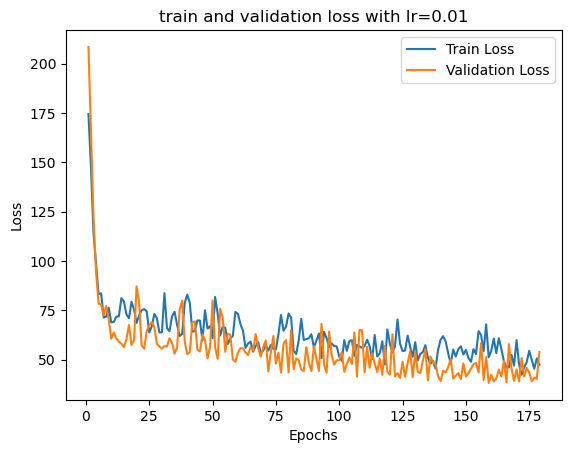

输入:torch.Size([32, 110]),标签:torch.Size([32, 110, 110])
输入:torch.Size([3, 110]),标签:torch.Size([3, 110, 110])
Test Loss: 43.2376
Test RMSE: 6.4193 Test MAE: 1.2447
-------------------不同时间步上---------------------
-----真实值------
[[  0. 191.   0.  20.   3.   3.  44.  81.]
 [260.   0.   0.  15.   4.   6.  47.  18.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  9.  11.   3.   0.  28.  94.  83.  53.]
 [  7.   0.   0.  22.   0.  23.   7.  17.]
 [ 10.   3.   0.  30.  37.   0.  27.  37.]
 [ 40.  31.   3.  68.  19.  91.   0. 686.]
 [136.  68.   0. 164.  24.  85. 712.   0.]]
-----预测值-----
[[  0. 236.   1.  13.   5.   9.  32.  72.]
 [236.  -0.   1.   8.   5.   7.  20.  32.]
 [  1.   1.  -0.   2.   0.   1.   2.   2.]
 [ 14.   8.   2.  -0.  77.  64.  51.  71.]
 [  8.   4.  -0.  59.  -0.  35.  13.  19.]
 [ 14.   7.   1.  49.  33.   0.  61.  85.]
 [ 29.  18.  -0.  47.  15.  80.   0. 475.]
 [ 80.  32.   1.  84.  22.  85. 486.  -0.]]
-----真实值------
[[  0. 300.   0.   7.   7.   6.  74. 123.]
 [249.   0.   

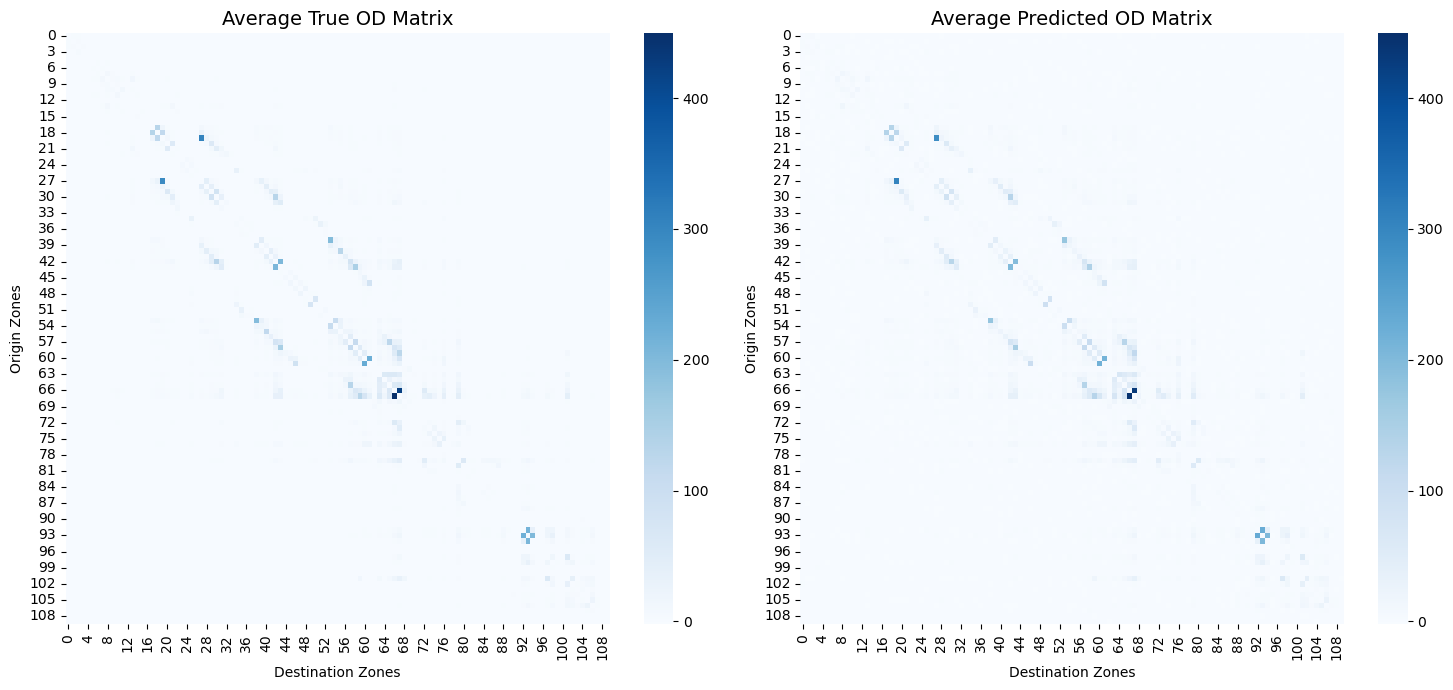

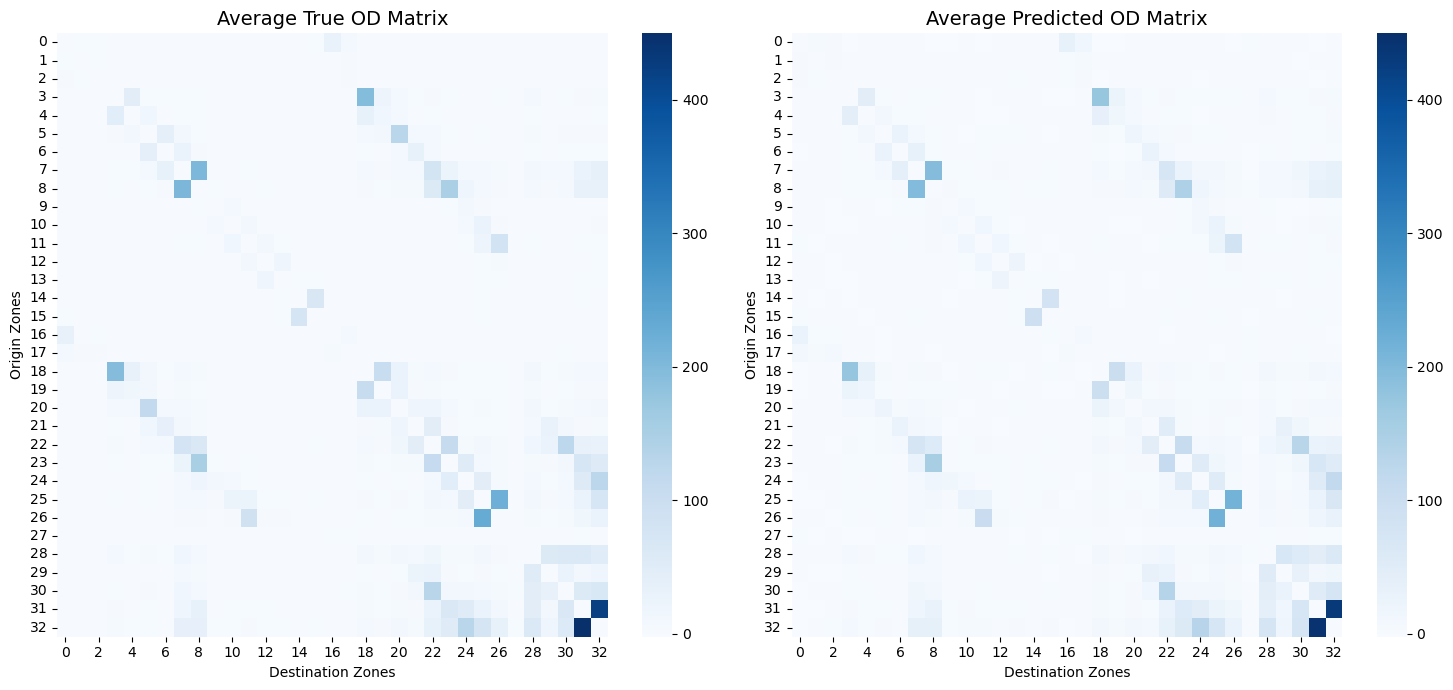

In [12]:
# 主程序
def main():
    train_loader, val_loader, test_loader, temp, freq = load_data()
    model = ODModel(N=110,temp=temp,freq=freq)  # N为区域数

   
    lr = 0.01  # best lr = 0.01
    train_model(model, train_loader, val_loader, epochs=2000, patience=20, learning_rate=lr, load=0)

    # 测试模型
    test_model(model, test_loader, lr=lr)


if __name__ == "__main__":
    main()